## Import Python Library


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
import shutil
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

## Prepare dataset



In [ ]:
# Mount data first
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# https://drive.google.com/drive/folders/1nypmMODHXMkBs25Vjvo27KutZJNxWluE?usp=sharing
# !unzip "drive/MyDrive/Skin-detector/Mpox-skin.zip" -d "drive/MyDrive/skin-disease-detector"

# End-to-end Skin Disease Detection
This model builds by Group3people image dectector using Tensorflow.

## 1.Problem
  Identifying types of skin which is good or bad, and give the percentage of disease a model can learn and give us information.
## 2.Data
  The data I'm using is a part of Kaggle project Mbox Skin Lesion Dataset
  https://www.kaggle.com/datasets/joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20/data
## 3.Evaluation
  The evaluation is a file with prediction probabilities for each skin disease of each test image
## 4.Features
  Some informations about the data:
  * I'm dealing with images (unstructured data) so it's probably best I use deep learning/transfer learning
  * There are 5 diseases of skin which is commonly seen in the real life and 1 for healthy skin
  * There are over 450+ images which I
 used in this project

### Get workspace ready

* Import TensorFlow 2.0
* Make sure using the GPU

In [ ]:
import tensorflow as tf
print(tf.__version__)
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

2.14.0
GPU available


### Getting Data Ready
With all machine learning models, data has to be numberical format. So that's all I need to do first, it called numberical representations.

Now start by accessing the data and checking out the labels

In [ ]:
labels_csv = pd.read_csv('drive/MyDrive/Skin-disease-detector/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

               id     disease
count         537         537
unique        537           6
top     CHP_01_01  Monkeyprox
freq            1         202
          id      disease
0  CHP_01_01  Chickenprox
1  CHP_03_01  Chickenprox
2  CHP_04_01  Chickenprox
3  CHP_04_02  Chickenprox
4  CHP_04_03  Chickenprox


In [ ]:
labels_csv.head()

,id,disease
0,CHP_01_01,Chickenprox
1,CHP_03_01,Chickenprox
2,CHP_04_01,Chickenprox
3,CHP_04_02,Chickenprox
4,CHP_04_03,Chickenprox


<Axes: >

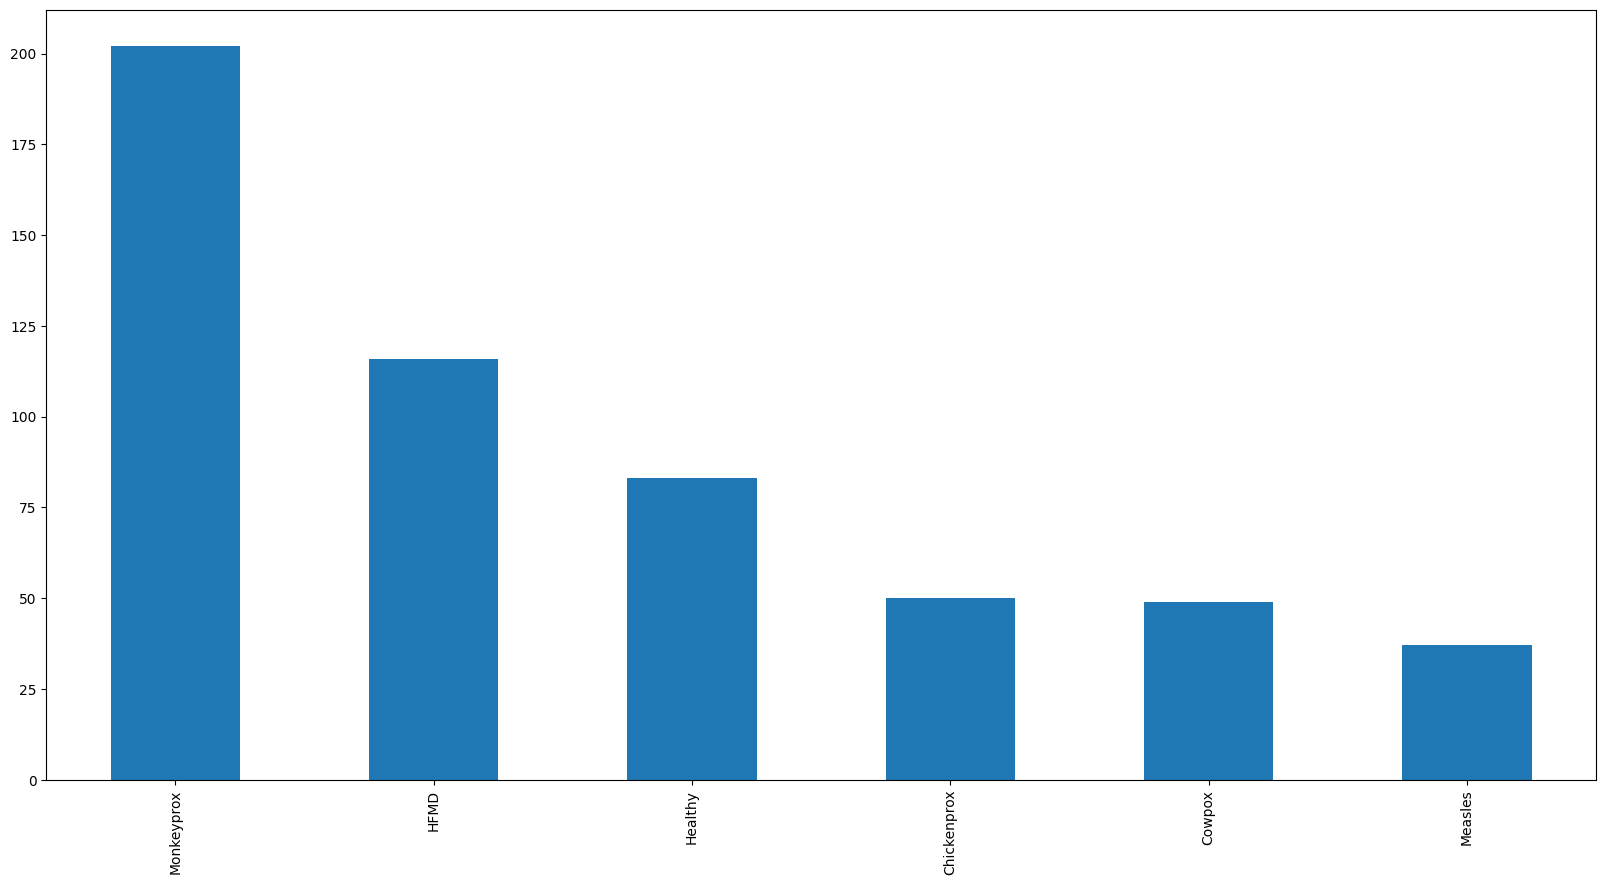

In [ ]:
labels_csv["disease"].value_counts().plot.bar(figsize=(20,10))

## Data Agumentation
- Our data doesn't have the same amount of images in each class, which would be sometimes difficult for model to predict with high accuracy.
- To prevent overfitting and make model easy to learn, we need to use a method called "Data Agumentation" which increase the amount of images so that they has the same value through each class.

<Axes: >

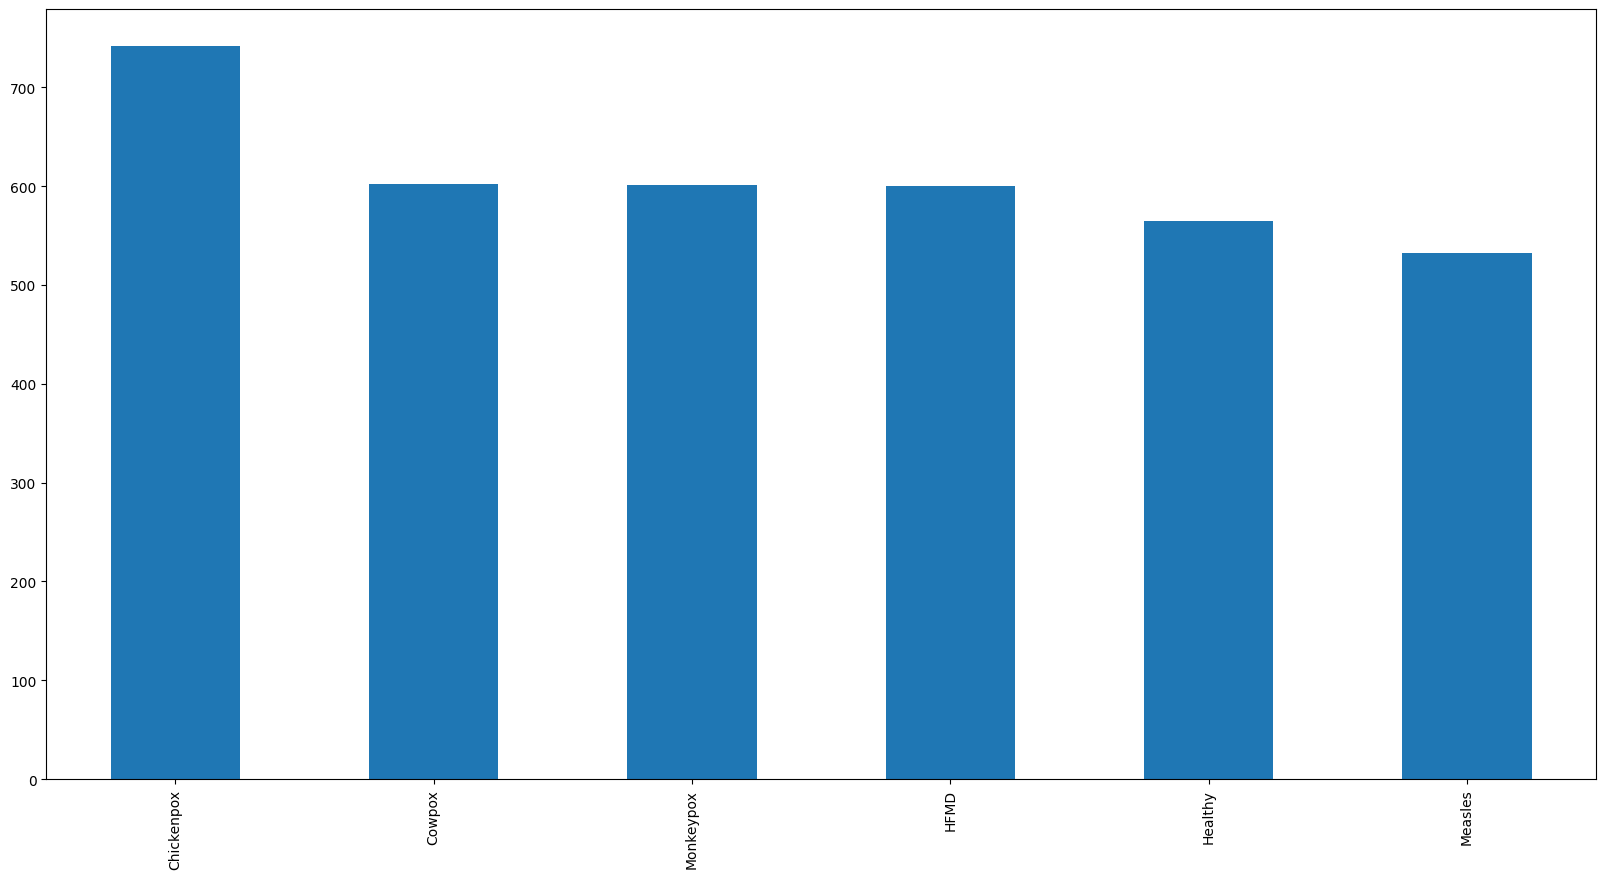

In [ ]:
augmented_df = pd.read_csv("drive/MyDrive/Skin-disease-detector/labels_augmented.csv")
augmented_df["disease"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
print(labels_csv["disease"].value_counts().median())
print(augmented_df["disease"].value_counts().median())

66.5
600.5


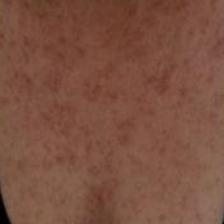

In [ ]:
#View an image
from IPython.display import Image
Image("drive/MyDrive/Skin-disease-detector/Augmented Images/Train/MSL_46_01_ORIGINAL.jpg")

### Getting image and their labels

Get a list of all of image file pathnames

In [ ]:
#Create pathnames from image ID
filenames = ["drive/MyDrive/Skin-disease-detector/Augmented Images/Train/" + fname +".jpg" for fname in augmented_df["id"]]
filenames[:10]

['drive/MyDrive/Skin-disease-detector/Augmented Images/Train/CHP_01_01_1.jpg',
 'drive/MyDrive/Skin-disease-detector/Augmented Images/Train/CHP_01_01_2.jpg',
 'drive/MyDrive/Skin-disease-detector/Augmented Images/Train/CHP_01_01_3.jpg',
 'drive/MyDrive/Skin-disease-detector/Augmented Images/Train/CHP_01_01_4.jpg',
 'drive/MyDrive/Skin-disease-detector/Augmented Images/Train/CHP_01_01_5.jpg',
 'drive/MyDrive/Skin-disease-detector/Augmented Images/Train/CHP_01_01_6.jpg',
 'drive/MyDrive/Skin-disease-detector/Augmented Images/Train/CHP_01_01_7.jpg',
 'drive/MyDrive/Skin-disease-detector/Augmented Images/Train/CHP_01_01_8.jpg',
 'drive/MyDrive/Skin-disease-detector/Augmented Images/Train/CHP_01_01_9.jpg',
 'drive/MyDrive/Skin-disease-detector/Augmented Images/Train/CHP_01_01_10.jpg']

### Now that's time I could think about my labels

In [ ]:
labels = augmented_df["disease"].to_numpy()
labels

array(['Chickenpox', 'Chickenpox', 'Chickenpox', ..., 'Monkeypox',
       'Monkeypox', 'Monkeypox'], dtype=object)

In [ ]:
len(labels)

3642

### I need to check whether the labels I got fully match and fullfill in the dataset

In [ ]:
if(len(labels) == len(filenames)) :
  print("Fully fill")
else :
  print("Not sure")

Fully fill


In [ ]:
# Find the unique labels values
unique_disease = np.unique(labels)
unique_disease

array(['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox'],
      dtype=object)

In [ ]:
# Turn the labels into a boolean array
boolean_labels = [label == unique_disease for label in labels]

### Creating Validation Test


In [ ]:
X = filenames
y = boolean_labels
NUM_IMAGES = len(augmented_df)
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)
print(y)

[array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, False, False, False]), array([ True, False, False, Fa

### Let's back to the model image processing
I would convert image to numpy array


In [ ]:
image = plt.imread(filenames[42])
IMG_SIZE = 224

In [ ]:
def process_image(image_path):
    # Read
    image = tf.io.read_file(image_path)
    # 3 Channels Color, turn in to numberical Tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image

# I would get all the label and image fit with that.
def get_image_label(image_path, label):
    image = process_image(image_path)
    return image, label

### Now I need to turn all of my images to batch which can run better and reduce times cost building a model

In [ ]:
BATCH_SIZE = 32

# Turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        print("Creating test data batches")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    elif valid_data:
        print("Creating validation data batches")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else:
        print("Creating training data bathes")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data = data.map(get_image_label)
        data_batch = data.batch(BATCH_SIZE)
    return data_batch


train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data bathes
Creating validation data batches


### Let's try a little bit about what would we do with image

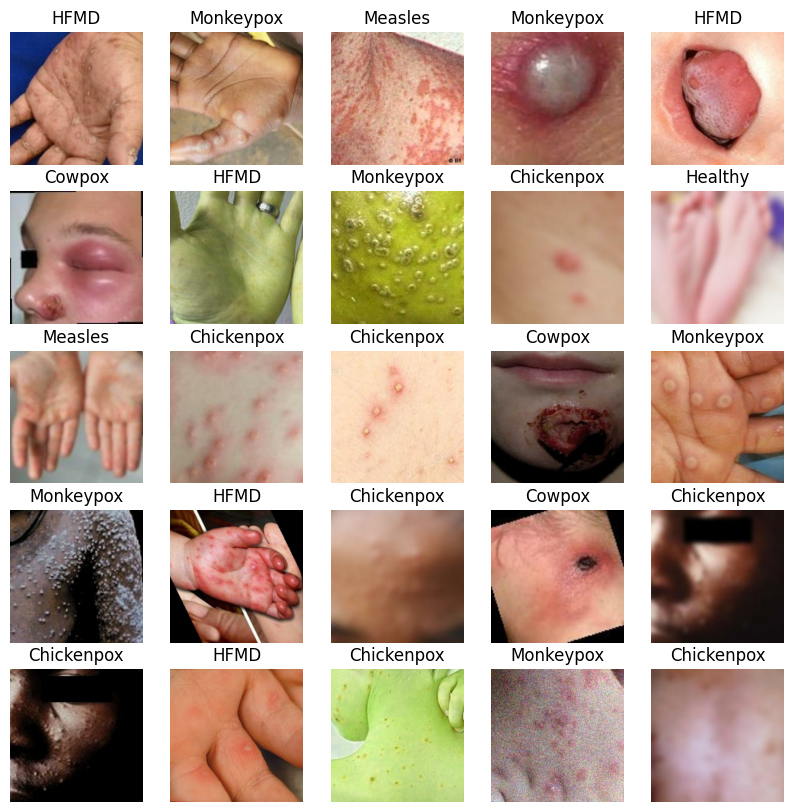

In [ ]:
def show_25_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(unique_disease[labels[i].argmax()])
        plt.axis("off")


train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)
# plt.show()

### Now it's the toughest thing in machine learning build, let's create our model
But at first, I need to set up my input shape w batch I build, height and colors
* I used 3 basic colors : red, blue and yellow

And that's how model learn our images through number, it transfered image to bit 0 and 1, then it preprocessing with machine learning algorithms through pixels and sum of that to 3x3 or 2x2 which CNN architechture can understand and load model.

In [ ]:
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(unique_disease)

### CNN Architechture
A convolution layer when applied to images is that it slides over the image spatially, computing dot products; each unit in the layer shares one set of weights.

Now I will create a function contain CNN architechture whose name is create_model

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output and add dense layers
    model.add(Flatten())
    model.add(Dense(units=OUTPUT_SHAPE, activation='relu'))
    model.add(Dense(units=OUTPUT_SHAPE, activation='softmax'))

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer='adam',
        metrics=["accuracy"]
    )
    model.build(INPUT_SHAPE)
    return model


### Prevent our model from overfitting

 We could know that our model can be overfitting if they didnt see an image that they see before. But not our model, bc there has to be meaned with some pictures has the same disease with our data huh ?! That would take time but worth a look

 * We could use keras.callbacks.EarlyStopping as whenever our model seem to be good, it could stop our model from overfitting by give them the suitable time learning whenever our accuracy seems to be balanced at a time

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                                                   patience=3)

### Build model

After create model, I would use train_data and create epochs variable to train our model, then testing my model real-time with validation_data file which I used as a alternative of test_data to advoid overfitting

### Build an epochs parameters for model

In [ ]:
epochs = 100

In [ ]:
def train_model():
    model = create_model()
    model.fit(x=train_data,
              epochs=epochs,
              validation_data=val_data,
              validation_freq=1,  # check validation metrics every epoch
              )
    return model


model = train_model()

Epoch 1/100
91/92 [============================>.] - ETA: 0s - loss: 1.7906 - accuracy: 0.1902

KeyboardInterrupt: ignored

### Test our model with dataset from test file

In [ ]:
predictions = model.predict(val_data, verbose=1)
def get_pred_label(prediction_probabilities):
  return unique_disease[np.argmax(prediction_probabilities)]


def unbatchify(data):
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_disease[np.argmax(label)])
  return images, labels

val_images, val_labels = unbatchify(val_data)

23/23 [==============================] - 1s 54ms/step


# Let's use my model with 1 image first :D



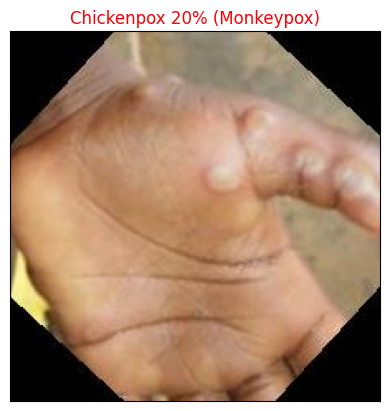

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
    pred_label = get_pred_label(pred_prob)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"
    plt.title("{} {:2.0f}% ({})".format(pred_label,
                                        np.max(pred_prob) * 100,
                                        true_label),
                                        color=color)

plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

# And it works :D
I would try to do differ couple things, now let's create some information to our picture, which is the percentage of diseases build in matplotlib

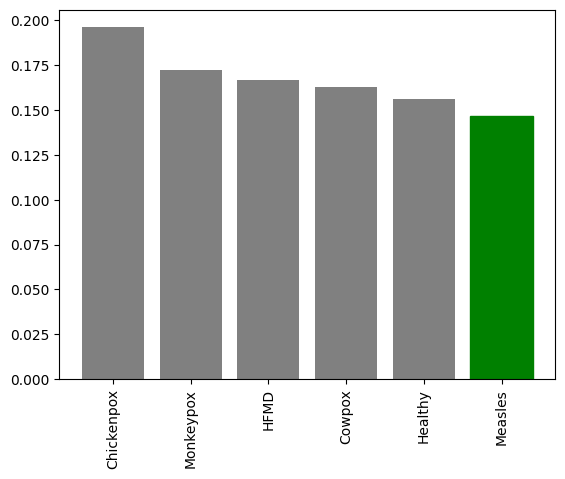

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
      pred_prob, true_label = prediction_probabilities[n], labels[n]
      pred_label = get_pred_label(pred_prob)
      top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
      top_10_pred_values = pred_prob[top_10_pred_indexes]
      top_10_pred_labels = unique_disease[top_10_pred_indexes]
      top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                         top_10_pred_values,
                         color="grey")
      plt.xticks(np.arange(len(top_10_pred_labels)),
                 labels=top_10_pred_labels,
                 rotation="vertical")
      if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
      else:
        pass
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

# That's great tho, but how about showing multiple images with the form above.

Sounds good, but.., howerver, let me try

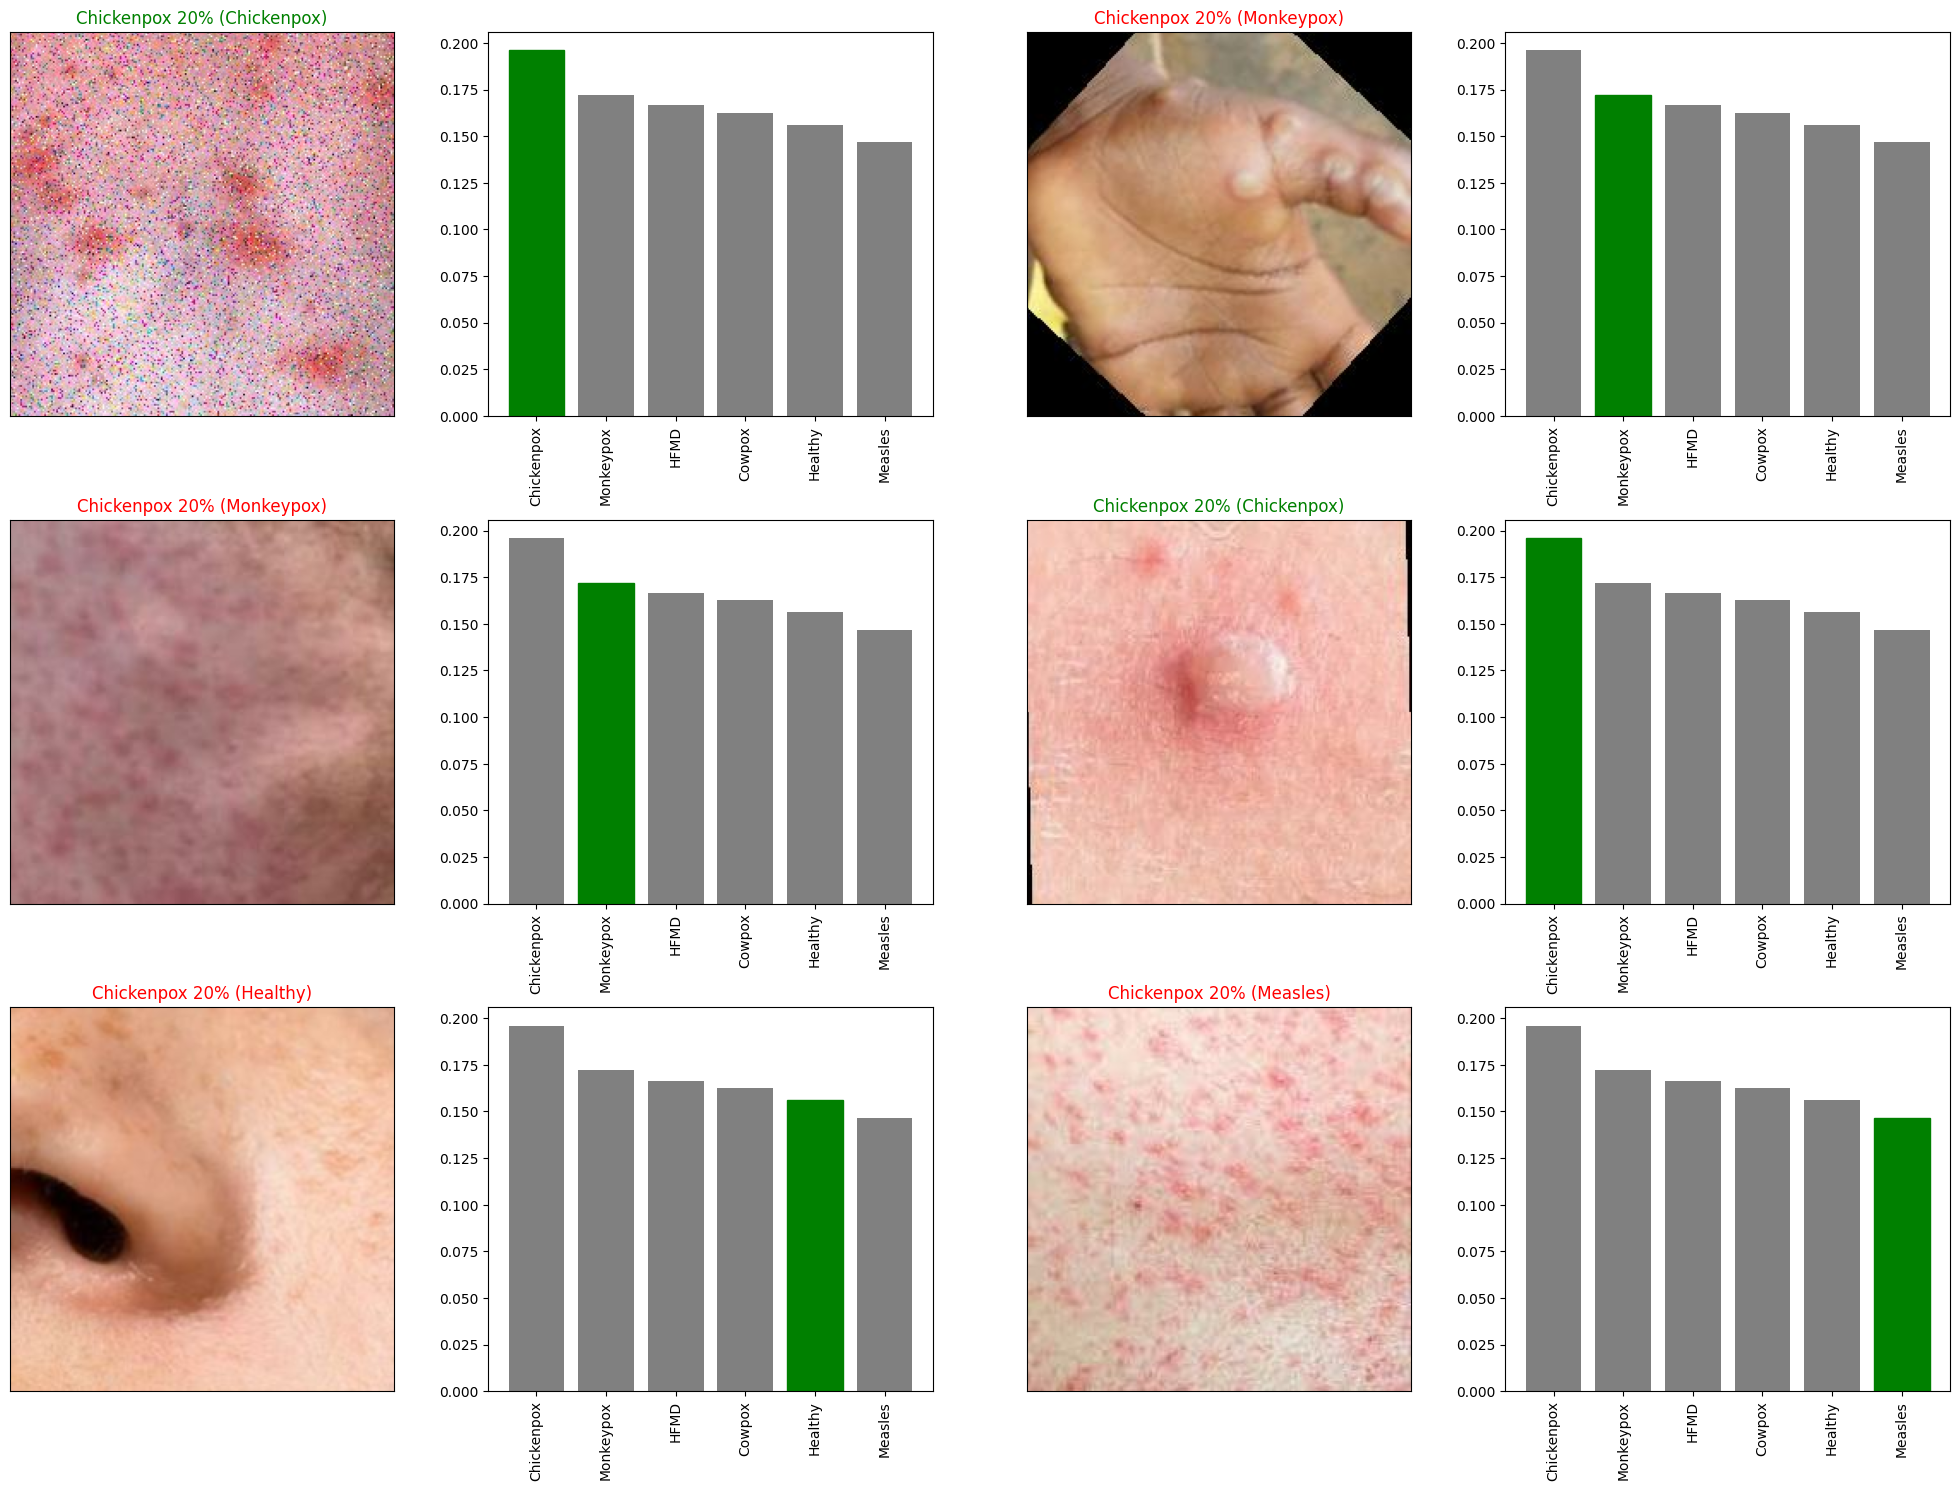

In [ ]:
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**NOW IT WORKS, WOULD BE GREAT, OMG I DO IT!!**

* Still figuring how model can predict the right disease when the accuracy of others be almost 100% like the 2nd column... *